Make simulate data faster using just a unique estimation for each run, and not estimate each time just a single number.

# Set Up

In [1]:
!git clone https://github.com/nudojacopo/thesis.git
from google.colab import drive
drive.mount('/content/drive')
root='/content/'
import sys
module_path = root+'thesis/src/SYN'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
!pip install powerlaw
from SYN_package.functions import *
from SYN_package.estimate_parameters import *
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import powerlaw
import warnings

Cloning into 'thesis'...
remote: Enumerating objects: 1551, done.
remote: Counting objects: 100% (278/278), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 1551 (delta 174), reused 256 (delta 164), pack-reused 1273
Receiving objects: 100% (1551/1551), 70.14 MiB | 10.22 MiB/s, done.
Resolving deltas: 100% (995/995), done.
Updating files: 100% (70/70), done.
Mounted at /content/drive


In [2]:

rd=pd.read_csv('/content/drive/MyDrive/thesis/data/reddit/reddit_PRO.csv')

fb=pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_news_PRO.csv')

vo=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_PRO.csv')

gb=pd.read_csv('/content/drive/MyDrive/thesis/data/gab/gab_PRO.csv')



fb=filter_first_h(fb,100)

gb=filter_first_h(gb,100)

rd=filter_first_h(rd,100)

vo=filter_first_h(vo,100)


names = ['gb','rd','fb','vo']
datas = [gb,rd,fb,vo]


## Parameter's Choice

### T0

#### Observed data from different platforms

The calculated proportions reveal interesting insights across different social media platforms regarding the temporal distances from birth in relation to specific events. For Reddit, approximately 15.0\% of the data points have temporal distances less than 0.02, while a significant 95.6\% fall under the 0.24 threshold. Voat shows a slightly higher proportion at 31.9\% below 0.02 and 95.0\% below 0.24, suggesting a comparable trend with Reddit but slightly fewer close temporal events. Gab, on the other hand, exhibits a notably higher proportion of 44.0\% below 0.02 and 92.1\% below 0.24, indicating potentially more concentrated temporal events compared to Reddit and Voat. Facebook, in contrast, shows a lower proportion of 27.4\% below 0.02 and 81.5\% below 0.24, suggesting a different distribution of temporal distances relative to events compared to the other platforms.


In [ ]:
# Calculating the proportion of values less than 0.02 for each dataset
print(np.mean(rd['temporal_distance_birth_base_100h'] < 0.02))
print(np.mean(vo['temporal_distance_birth_base_100h'] < 0.02))
print(np.mean(fb['temporal_distance_birth_base_100h'] < 0.02))
print(np.mean(gb['temporal_distance_birth_base_100h'] < 0.02))

# Calculating the proportion of values less than 0.24 for each dataset
print(np.mean(rd['temporal_distance_birth_base_100h'] < 0.24))
print(np.mean(vo['temporal_distance_birth_base_100h'] < 0.24))
print(np.mean(fb['temporal_distance_birth_base_100h'] < 0.24))
print(np.mean(gb['temporal_distance_birth_base_100h'] < 0.48))


0.9262699785230273


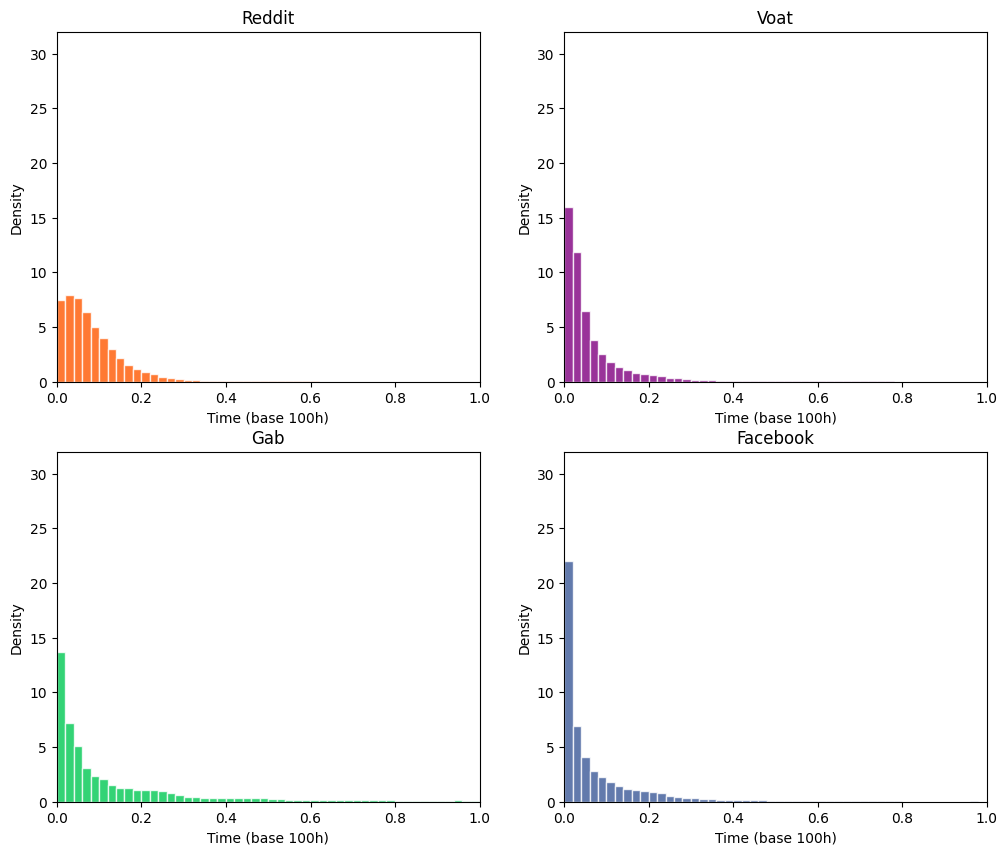

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

# Example DataFrames (replace these with actual data)
import pandas as pd

# Define color palette
palette = {
    'Reddit': '#FF5700',   # Reddit orange
    'Voat': '#800080',     # Voat purple
    'Facebook': '#3b5998', # Facebook blue
    'Gab': '#00c853'       # Gab green
}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# Define common x and y limits
xlim = (0, 1)
ylim = (0, 32)  # Adjust based on the data for appropriate scaling

# Plot histograms for the different distributions in separate subplots

# Reddit
axes[0, 0].hist(rd['temporal_distance_birth_base_100h'], bins=50, alpha=0.8, label='Reddit', color=palette['Reddit'], density=True, edgecolor='white')
axes[0, 0].set_title('Reddit')
axes[0, 0].set_xlim(xlim)
axes[0, 0].set_ylim(ylim)
axes[0, 0].set_xlabel('Time (base 100h)')
axes[0, 0].set_ylabel('Density')

# Voat
axes[0, 1].hist(vo['temporal_distance_birth_base_100h'], bins=50, alpha=0.8, label='Voat', color=palette['Voat'], density=True, edgecolor='white')
axes[0, 1].set_title('Voat')
axes[0, 1].set_xlim(xlim)
axes[0, 1].set_ylim(ylim)
axes[0, 1].set_xlabel('Time (base 100h)')
axes[0, 1].set_ylabel('Density')

# Gab
axes[1, 0].hist(gb['temporal_distance_birth_base_100h'], bins=50, alpha=0.8, label='Gab', color=palette['Gab'], density=True, edgecolor='white')
axes[1, 0].set_title('Gab')
axes[1, 0].set_xlim(xlim)
axes[1, 0].set_ylim(ylim)
axes[1, 0].set_xlabel('Time (base 100h)')
axes[1, 0].set_ylabel('Density')

# Facebook
axes[1, 1].hist(fb['temporal_distance_birth_base_100h'], bins=50, alpha=0.8, label='Facebook', color=palette['Facebook'], density=True, edgecolor='white')
axes[1, 1].set_title('Facebook')
axes[1, 1].set_xlim(xlim)
axes[1, 1].set_ylim(ylim)
axes[1, 1].set_xlabel('Time (base 100h)')
axes[1, 1].set_ylabel('Density')



# Show the plot
plt.show()

### ZIE

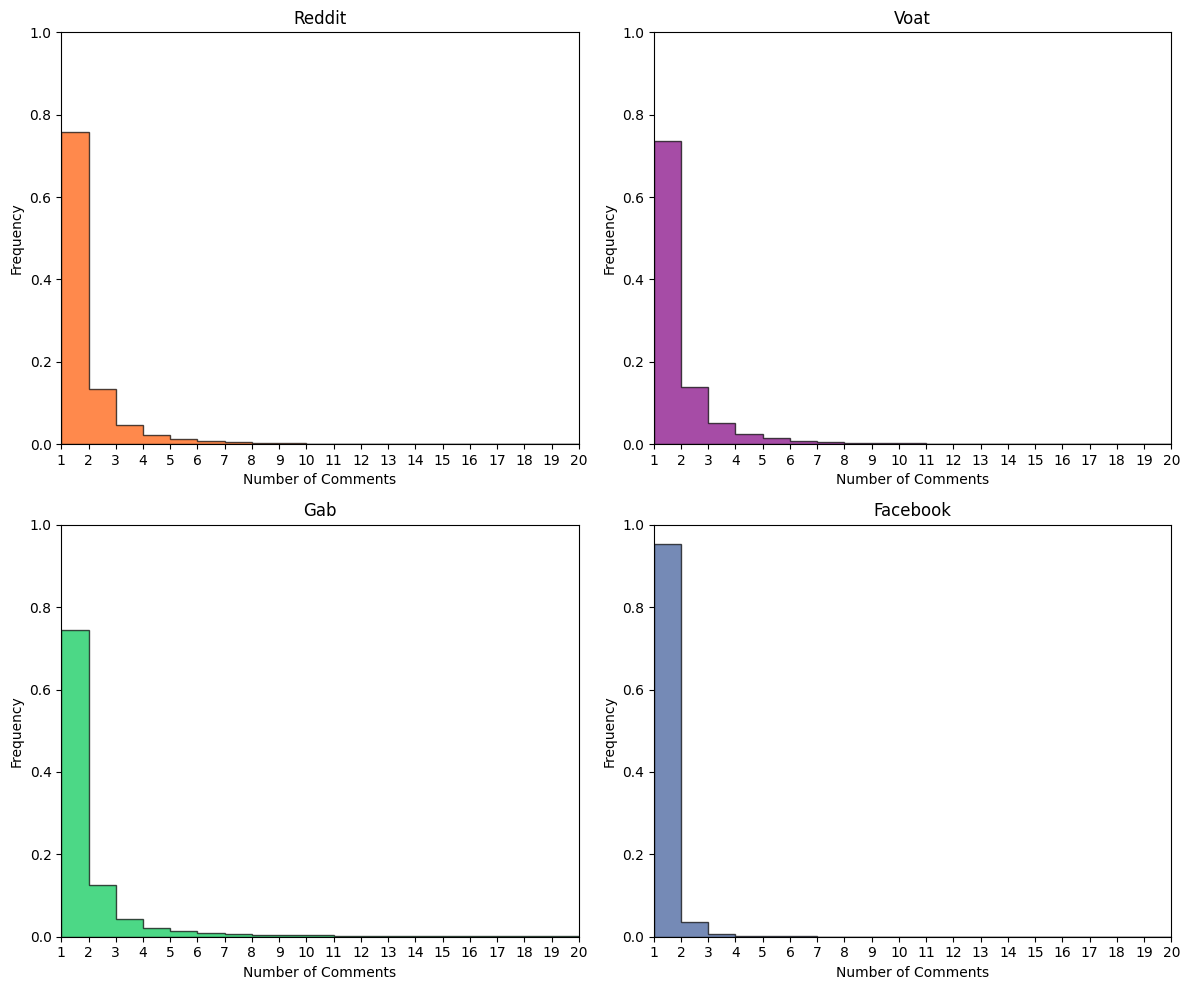

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example DataFrames (replace these with your actual data)
# Assuming size_of_interaction_voat, size_of_interaction_reddit, size_of_interaction_gab, size_of_interaction_facebook are defined

# Define color palette
palette = {
    'Reddit': '#FF5700',   # Reddit orange
    'Voat': '#800080',     # Voat purple
    'Facebook': '#3b5998', # Facebook blue
    'Gab': '#00c853'       # Gab green
}

# Define bins
bins = np.arange(1, 44)

# Create subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Reddit
axs[0, 0].hist(size_of_interaction_reddit, bins=bins, alpha=0.7, edgecolor='black', color=palette['Reddit'], histtype='stepfilled', density=True)
axs[0, 0].set_title('Reddit')
axs[0, 0].set_xlim(1, 20)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xlabel('Number of Comments')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_xticks(np.arange(1, 21))

# Voat
axs[0, 1].hist(size_of_interaction_voat, bins=bins, alpha=0.7, edgecolor='black', color=palette['Voat'], histtype='stepfilled', density=True)
axs[0, 1].set_title('Voat')
axs[0, 1].set_xlim(1, 20)
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_xlabel('Number of Comments')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_xticks(np.arange(1, 21))

# Gab
axs[1, 0].hist(size_of_interaction_gab, bins=bins, alpha=0.7, edgecolor='black', color=palette['Gab'], histtype='stepfilled', density=True)
axs[1, 0].set_title('Gab')
axs[1, 0].set_xlim(1, 20)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlabel('Number of Comments')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_xticks(np.arange(1, 21))

# Facebook
axs[1, 1].hist(size_of_interaction_facebook, bins=bins, alpha=0.7, edgecolor='black', color=palette['Facebook'], histtype='stepfilled', density=True)
axs[1, 1].set_title('Facebook')
axs[1, 1].set_xlim(1, 20)
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_xlabel('Number of Comments')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_xticks(np.arange(1, 21))

# Adjust layout
plt.tight_layout()

# Save the plot with a fixed size
fig.set_size_inches(12, 10)
plt.savefig('7.png', dpi=300)  # Adjust dpi as needed

# Show the plot (optional)
plt.show()


### IAT

In [4]:
import pandas as pd

def process_platform(df, platform_name):
  df['last_comment']=df['sequential_number_of_comment_by_user_in_thread']==df['number_of_comments_by_user_in_thread'].copy()
  df=df.dropna(subset='IAT_user_thread').copy()
  df['time_difference']=df['IAT_user_thread']/(60*60*100)
  merged_df=df[df['last_comment']==False].copy()
  merged_df_final=df[df['last_comment']==True].copy()
  return merged_df,merged_df_final

# Process Facebook
IAT_fb,IAT_f_fb = process_platform(fb, 'Facebook')

IAT_f_fb['T']=1-(IAT_f_fb['temporal_distance_birth_base_100h']-IAT_f_fb['time_difference'])
IAT_f_fb['time']=IAT_f_fb['time_difference']/IAT_f_fb['T']

IAT_fb['T']=1-(IAT_fb['temporal_distance_birth_base_100h']-IAT_fb['time_difference'])
IAT_fb['time']=IAT_fb['time_difference']/IAT_fb['T']

# Process Reddit
IAT_rd,IAT_f_rd = process_platform(rd, 'Reddit')

IAT_f_rd['T']=1-(IAT_f_rd['temporal_distance_birth_base_100h']-IAT_f_rd['time_difference'])
IAT_f_rd['time']=IAT_f_rd['time_difference']/IAT_f_rd['T']

IAT_rd['T']=1-(IAT_rd['temporal_distance_birth_base_100h']-IAT_rd['time_difference'])
IAT_rd['time']=IAT_rd['time_difference']/IAT_rd['T']

# Process Gab
IAT_gb,IAT_f_gb = process_platform(gb, 'Gab')

IAT_f_gb['T']=1-(IAT_f_gb['temporal_distance_birth_base_100h']-IAT_f_gb['time_difference'])
IAT_f_gb['time']=IAT_f_gb['time_difference']/IAT_f_gb['T']

IAT_gb['T']=1-(IAT_gb['temporal_distance_birth_base_100h']-IAT_gb['time_difference'])
IAT_gb['time']=IAT_gb['time_difference']/IAT_gb['T']


# Process Voat
IAT_vo,IAT_f_vo = process_platform(vo, 'Voat')

IAT_f_vo['T']=1-(IAT_f_vo['temporal_distance_birth_base_100h']-IAT_vo['time_difference'])
IAT_f_vo['time']=IAT_f_vo['time_difference']/IAT_f_vo['T']

IAT_vo['T']=1-(IAT_vo['temporal_distance_birth_base_100h']-IAT_vo['time_difference'])
IAT_vo['time']=IAT_vo['time_difference']/IAT_vo['T']



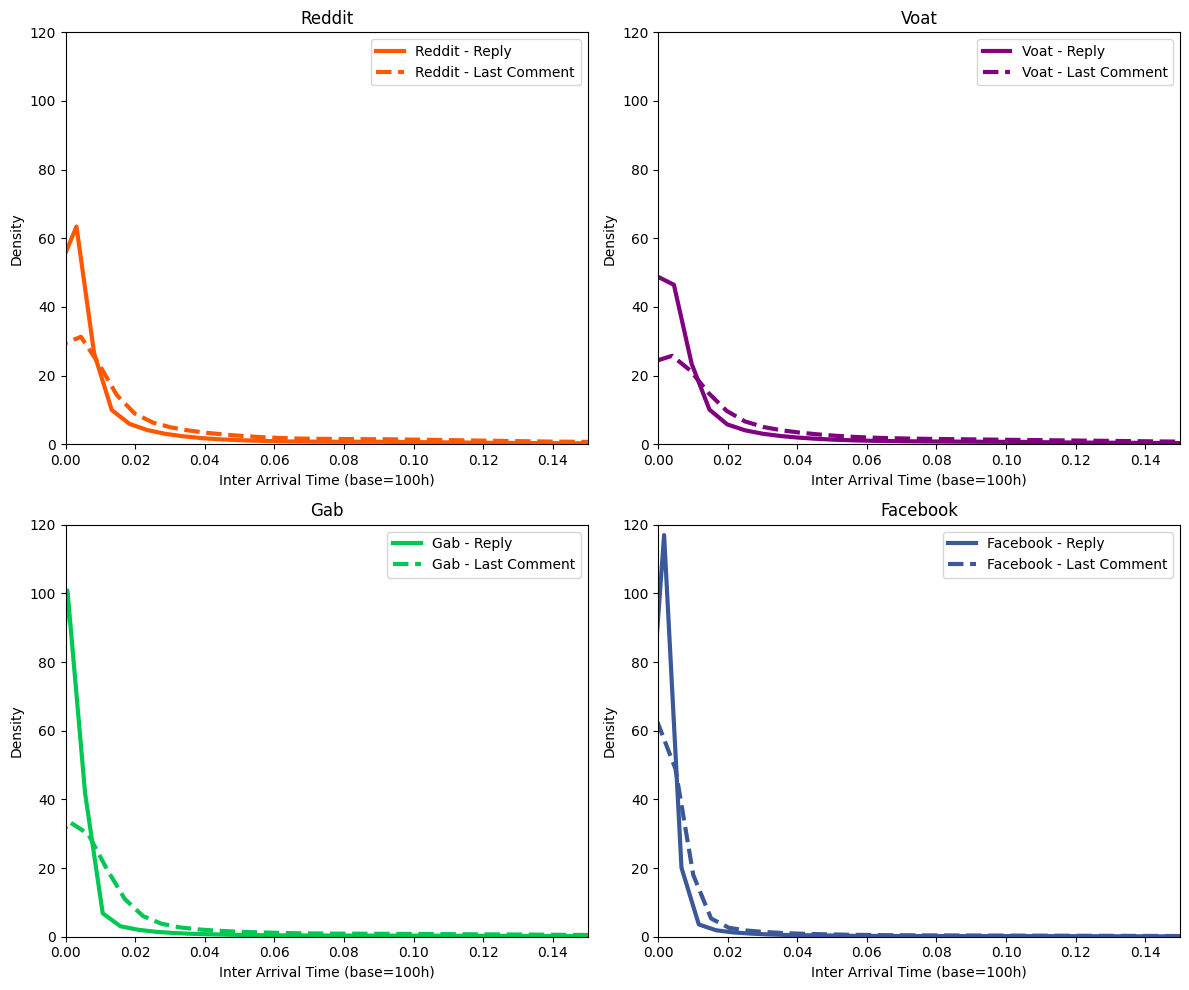

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example data (replace with your actual data)
# Assuming you have your data loaded correctly into DataFrames: IAT_fb, IAT_f_fb, IAT_rd, IAT_f_rd, IAT_yt, IAT_f_yt, IAT_vo, IAT_f_vo
# Each DataFrame has a column 'time_difference'

# Define color palette
# Define color palette
palette = {
    'Reddit': '#FF5700',   # Reddit orange
    'Voat': '#800080',     # Voat purple
    'Facebook': '#3b5998', # Facebook blue
    'Gab': '#00c853'       # Gab green
}

# Create subplots with sorted order: Reddit, Voat, Gab, Facebook
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Reddit
sns.kdeplot(data=IAT_rd['time_difference'], label='Reddit - Reply', color=palette['Reddit'], linewidth=3, ax=axes[0, 0])
sns.kdeplot(data=IAT_f_rd['time_difference'], label='Reddit - Last Comment', color=palette['Reddit'], linestyle='--', linewidth=3, ax=axes[0, 0])
axes[0, 0].set_xlim(0, 0.15)
axes[0, 0].set_ylim(0, 120)
axes[0, 0].set_title('Reddit')
axes[0, 0].legend()

# Voat
sns.kdeplot(data=IAT_vo['time_difference'], label='Voat - Reply', color=palette['Voat'], linewidth=3, ax=axes[0, 1])
sns.kdeplot(data=IAT_f_vo['time_difference'], label='Voat - Last Comment', color=palette['Voat'], linestyle='--', linewidth=3, ax=axes[0, 1])
axes[0, 1].set_xlim(0, 0.15)
axes[0, 1].set_ylim(0, 120)
axes[0, 1].set_title('Voat')
axes[0, 1].legend()

# Gab
sns.kdeplot(data=IAT_gb['time_difference'], label='Gab - Reply', color=palette['Gab'], linewidth=3, ax=axes[1, 0])
sns.kdeplot(data=IAT_f_gb['time_difference'], label='Gab - Last Comment', color=palette['Gab'], linestyle='--', linewidth=3, ax=axes[1, 0])
axes[1, 0].set_xlim(0, 0.15)
axes[1, 0].set_ylim(0, 120)
axes[1, 0].set_title('Gab')
axes[1, 0].legend()

# Facebook
sns.kdeplot(data=IAT_fb['time_difference'], label='Facebook - Reply', color=palette['Facebook'], linewidth=3, ax=axes[1, 1])
sns.kdeplot(data=IAT_f_fb['time_difference'], label='Facebook - Last Comment', color=palette['Facebook'], linestyle='--', linewidth=3, ax=axes[1, 1])
axes[1, 1].set_xlim(0, 0.15)
axes[1, 1].set_ylim(0, 120)
axes[1, 1].set_title('Facebook')
axes[1, 1].legend()

# Customizing the appearance of the plots
for ax in axes.flat:
    ax.set_xlabel('Inter Arrival Time (base=100h)')
    ax.set_ylabel('Density')
plt.tight_layout()

# Save the plot with the original size
plt.savefig('8.png', dpi=300)  # Adjust dpi as needed

plt.show()
